# Spaceship.

## Task description

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## Files and Data Fields Descriptions


### **train.csv**  - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

Your task is to predict the value of Transported for the passengers in this set.

### **sample_submission.csv** - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False.



### Here are the first 5 rows of the data:

In [2]:
import pandas as pd

# Random seed for reproducibility
SEED = 123
# A file to save global variables
global_variables = pd.DataFrame({'SEED': [SEED]})
global_variables.to_csv('global_variables.csv')
global_variables.to_csv('functions/global_variables.csv')

train_unprocessed = pd.read_csv('datasets/train.csv')
test_unprocessed = pd.read_csv('datasets/test.csv')

train_size = len(train_unprocessed)
train_size_file = pd.DataFrame([train_size])
train_size_file.to_csv('train_size.csv')

# Collect Passenger Ids in the test dataset into a separate variable
test_Ids = test_unprocessed['PassengerId']
test_Ids.to_csv('test_Ids.csv')

data_unprocessed = pd.concat([train_unprocessed, test_unprocessed]).reset_index(drop=True)

data_unprocessed.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
data_unprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


## 00. Baseline

First, we'll make a baseline prediction, that all passengers were Transported. We'll calculate the Score of this prediction on the train set (for future cases, we'll calculate separately Train Score and Cross-validation Score, but in this case, these scores will be equal to Train Score, since our cross-validation will be stratified).

Our Score = (Average Cross-validation ROC AUC) - (1 Standard deviation of Cross-validation ROC AUCs).

In this simple case, Standard deviation will be 0 (again, cross-validation is stratified), so Score for this case will be just Train ROC AUC.

We'll save our intermediate results in DataFrame scores_df:

In [4]:
from sklearn.metrics import roc_auc_score

train_predictions_00 = pd.DataFrame(data=train_unprocessed['Transported'], columns=['Transported'])
train_predictions_00['Transported'] = True

scores_df = pd.DataFrame({'Comment': [], 'Train Score': [], 'Cross-val Score': [], 'Test Accuracy': []})

score_00 = roc_auc_score(train_unprocessed['Transported'], train_predictions_00['Transported'])

scores_df.loc[0, 'Comment'] = 'All True'
scores_df.loc[0, 'Train Score'] = score_00
scores_df.loc[0, 'Cross-val Score'] = score_00
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.5,0.5,NaN


ROC AUC is 0.5, which means our predictions are no better than random guessing

Now, we'll make a submission to Kaggle to see our Test Accuracy. We won't use Test Accuracy in making decisions, but we'll use it to catch bugs in our Score calculations:

In [5]:
test_predictions_00 = pd.DataFrame([True] * len(test_unprocessed), columns=['Transported'])
submission_00 = pd.concat([test_unprocessed['PassengerId'], test_predictions_00], axis=1)

submission_00.to_csv('submissions/submission_00.csv', index=False)

scores_df.loc[0, 'Test Accuracy'] = 0.50689
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.5,0.5,0.50689


## 01. Numerical features with 0's for missing values

Now, we'll make predictions on the numerical features only, filling missing values with zeros:

In [6]:
# Drop non-numerical columns
train = train_unprocessed.select_dtypes(include=['int', 'float'])
test = test_unprocessed.select_dtypes(include=['int', 'float'])

# Put the target variable back to the train dataset
train = pd.concat([train, train_unprocessed['Transported']], axis=1)

# Fill missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

train.to_csv('new_datasets/train_01.csv')
test.to_csv('new_datasets/test_01.csv')

We'll use XGBoost with default parameters as our first estimator. 

### Choosing number of cross-validation splits

For calculating Score, I wrote get_score function, that is located in ['functions/get_score.py'](functions/get_score.py). This function takes a number of StratifiedKFold slits as one of its arguments. 

We want such number of splits that give us the best balance between bias and variance. For the sake of run time, the optimal number of splits calculation is done in a separate file: ['functions/n_splits.py'](functions/n_splits.py).

The tradeoff sweetspot is at 3 splits.

In [7]:
N_SPLITS = 3
global_variables['N_SPLITS'] = N_SPLITS
global_variables.to_csv('global_variables.csv')
global_variables.to_csv('functions/global_variables.csv')

Let's find Scores and Test Accuracy for this number of splits:

In [8]:
# UNCOMMENT TO INSTALL XGBOOST
#!pip install xgboost
import xgboost as xgb

# Instantiate the regressor
model = xgb.XGBClassifier(random_state=SEED, n_jobs=-1)

from functions.get_score import get_score

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train, test, model, scores_df,
                                                                  comment="All numerical features with 0's for missing values")

In [9]:
submission.to_csv('submissions/submission_01.csv', index=False)

scores_df.loc[1, 'Test Accuracy'] = 0.7877
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.78770


## Hyperparameters tuning workflow description

For the sake of runtime and for convinience, we'll do all our hyperparameters tunings in separate files. Here is the workflow:

-) Notice the Report chapter number. For example, our next chapter, in which we'll do our first tining, is 02.

-) If you need to restart any study from scratch, go to ['functions/initialize_studies.ipynb'](functions/initialize_studies.ipynb), run the first cell to import packages, then run a cell with your current Report chapter number. The progress of that study will be deleted.

!!!ATTENTION!!! Do not run the whole initialize_studies notebook, or all the studies will be restarted (unless that is what you want). !!!ATTENTION!!!

-) The current study is in studies/Report_chapter_number.py. For example, next study will be in ['studies/02.py'](studies/02.py).

-) At the beginning of the study file, choose maximum run time and number of trials for the current run.

-) Hyperparameter tuning will be continued from the end of the previous run of this file.

-) At the end of the run, look at the best parameters. If some of the parameters are on the extreme ends of the search ranges, extend the ranges. The study progress will be kept.

-) At the end of the run, look at the total number of trials in study and the number of the best trial.

-) If results (Average cross-val scores) keep going up, re-run the file. Repeat until satisfied.

-) If results (Average cross-val scores) do not improve for a big number of trials, then go back to the current Report chapter and load results (see below).

For a simple exaple look at ['studies/test.ipynb'](studies/test.ipynb). This study maximizes sum of two numbers chosen from a set of integers.

## 02. Choosing numerical features

We'll find the set of numerical features that gives us the highest cross-validation Score:

In [10]:
import joblib
import optuna

study = joblib.load("studies/02.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8284518468994545
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True}


Here, "'Age': True" means that the best model was using 'Age' feature. 

All the features were selected by our hyperparameters search.

Note, that our best Score is equal to the Score from the 01, since we used the same set of features and same random seed. Let's put this score into scores_df for consistency:

In [11]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train, test, model, scores_df,
                                                                  comment="All numerical features are selected")
scores_df.loc[2, 'Test Accuracy'] = 0.7877
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.78770
2,All numerical features are selected,0.919507,0.828452,0.78770


## Categorical features

Let's look at our data column by column:

## 03. Group Size

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

The number of a passenger within their group is arbitrary, so we don't need it. However, group numbers may be important, so we'll create a new feature "Group":

In [12]:
train['Group'] = train_unprocessed['PassengerId'].str[:4]
test['Group'] = test_unprocessed['PassengerId'].str[:4]
print(train['Group'].info())
print(train['Group'].describe())
print('Unique Values:')
print(train['Group'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Group
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count     8693
unique    6217
top       4498
freq         8
Name: Group, dtype: object
Unique Values:
['0001' '0002' '0003' ... '9278' '9279' '9280']


We have 6217 separate Groups in the training set among 8693 entries.

We need to transform Group to numerical features. Since the number of categories is high, it may be unworthy to create dummy variables. We'll try Mean Target Encoding (the fuctions for Mean Target Encoding are based on work by Yauhen Babakhin):

In [13]:
from functions.target_encoding import mean_target_encoding

# We'll need to express Transported as 1 and 0 for Mean Target Encoding:
train['Transported'] = [1 if i else 0 for i in train['Transported']]

# Encode Group
train['Group_enc'], test['Group_enc'] = mean_target_encoding(train, test, 'Transported', 'Group', alpha=7.5)

test['Group_enc'].describe()

count    4.277000e+03
mean     5.036236e-01
std      3.475404e-14
min      5.036236e-01
25%      5.036236e-01
50%      5.036236e-01
75%      5.036236e-01
max      5.036236e-01
Name: Group_enc, dtype: float64

Oh, it seems that we have only one unique value for the Group_enc in the test set:

In [14]:
test['Group_enc'].unique()

array([0.50362361])

The reason is that there is no Groups that are common between the train and test sets:

In [15]:
list(set(train['Group']) & set(test['Group']))

[]

Therefore, distinguishing Groups is useless. However, we can use the Group column in another way: let's calculate the number of group members and assign it to "GroupSize" variable:

In [16]:
train['GroupSize'] = train.groupby('Group')['Group'].transform('count')
test['GroupSize'] = test.groupby('Group')['Group'].transform('count')

for dataset in [train, test]:
    print(dataset['GroupSize'].info())
    print(dataset['GroupSize'].describe())
    print('Unique Values:')
    print(dataset['GroupSize'].unique())
    

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: GroupSize
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        2.035546
std         1.596347
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         8.000000
Name: GroupSize, dtype: float64
Unique Values:
[1 2 3 6 4 7 5 8]
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: GroupSize
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        1.997428
std         1.537113
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: GroupSize, dtype: float64
Unique Values:
[1 2 3 5 4 8 6 7]


Now, let's select features again, now with GroupSize feature as an option:

In [17]:
train.to_csv('new_datasets/train_03.csv')
test.to_csv('new_datasets/test_03.csv')

study = joblib.load("studies/03.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8342087175928439
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True, 'GroupSize': True}


We improved our Score by adding Group Size! Let's put results in the table:

In [18]:
# Create sets with selected columns

selected_columns = []
for key, value in study.best_params.items():
    if value:
        selected_columns.append(key)

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="+ GroupSize")
submission.to_csv('submissions/submission_03.csv', index=False)
scores_df.loc[3, 'Test Accuracy'] = 0.7884
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.78770
2,All numerical features are selected,0.919507,0.828452,0.78770
3,+ GroupSize,0.932251,0.834209,0.78840


## Exploring missing values

PassengerId, and, therefore, GroupSize don't have missing values. Other columns, though, have missing values. Let's explore if there are some patterns in missing data:

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64


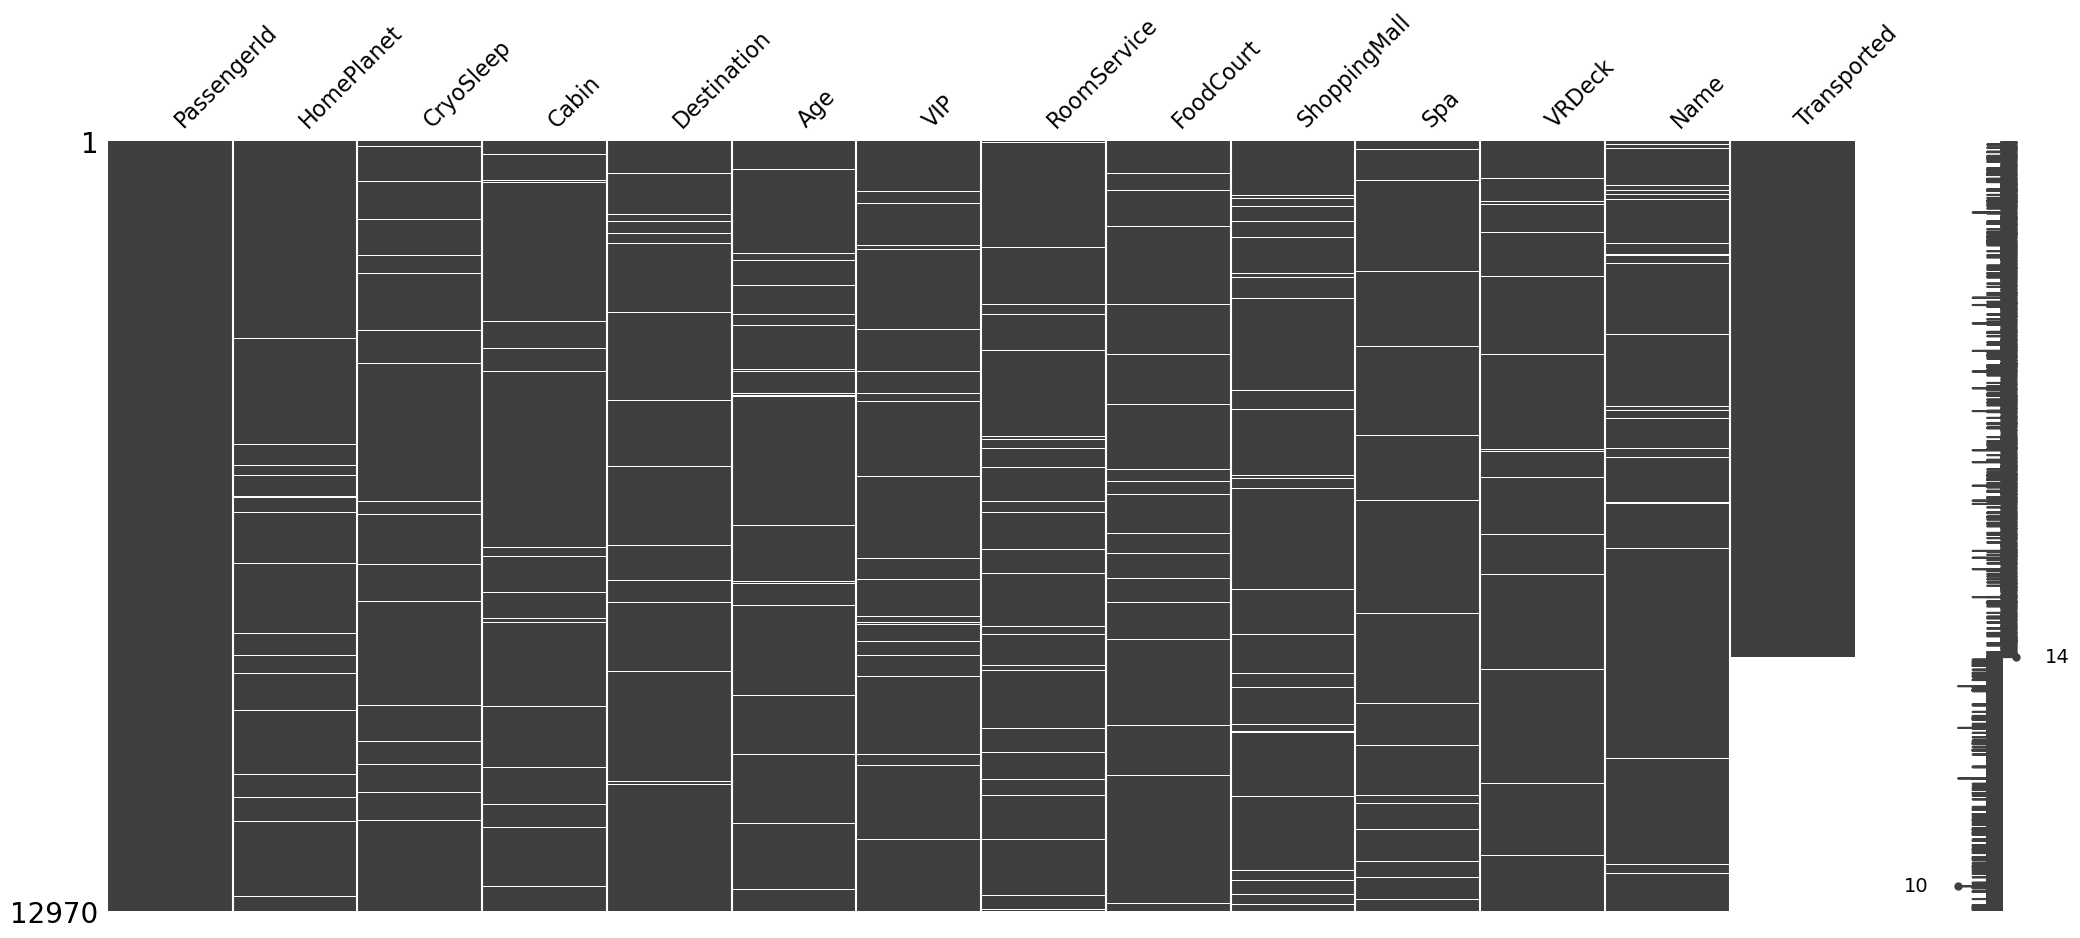

In [19]:
import missingno as msno
import matplotlib.pyplot as plt

# Print number of missing values in banking
print(data_unprocessed.isna().sum())

# Visualize missingness matrix
msno.matrix(data_unprocessed)
plt.show()

It seems that values are Missing At Random (Transported column is our target, it is missing in test data). We'll fill the missing values column by column, based on the description of the dataset.

## 04. Family Size

**Name** - The first and last names of the passenger.

We don't need the first names, so we'll strip them. 
Additionally, we may assume that passengers with the same last names in different Groups are not relatives. To avoid treating them as relatives, we will append Group names to all last names:

In [20]:
### !!!! FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

train = pd.concat([train, train_unprocessed['Name']], axis=1)
test = pd.concat([test, test_unprocessed['Name']], axis=1)

for data in [train, test]:
    data.Name = data.Name.str.split(' ', 1).str[1]
    data.Name = data.Name + data.Group

C:\Users\mikej\AppData\Local\Temp\ipykernel_26044\2091076608.py:7: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data.Name = data.Name.str.split(' ', 1).str[1]


We'll fill the missing values for Names based on the most common surname in their Group.
If a passenger is alone in their group, we'll name them by the name of their Group:

In [21]:
for data in [train, test]:
    # Iterate through all the rows with missing data
    for index in data[data['Name'].isna()].index:
        # Fill the missing values for lonely passengers:
        if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
            data.loc[index, "Name"] = data.loc[index, 'Group']
        # Fill the missing values for non-lonely passengers:
        else:
            data.loc[index, "Name"] = data[(data['Group'] == data.loc[index, 'Group']) & \
                    (data['Name'].isna() == False)]['Name'].mode()[0]

As you can see below, now Name doesn't have missing values:

In [22]:
for data in [train, test]:
    print(data['Name'].info())
    print(data['Name'].describe())
    print('Unique Values:')
    print(data['Name'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count               8693
unique              6491
top       Clemondsey9081
freq                   8
Name: Name, dtype: object
Unique Values:
['Ofracculy0001' 'Vines0002' 'Susent0003' ... 'Mondalley9278' 'Connon9279'
 'Hontichre9280']
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
4277 non-null   object
dtypes: object(1)
memory usage: 33.5+ KB
None
count          4277
unique         3200
top       Casez6332
freq              8
Name: Name, dtype: object
Unique Values:
['Carsoning0013' 'Peckers0018' 'Unhearfus0019' ... 'Pore9271' 'Conale9273'
 'Leonzaley9277']


Since we don't have common Groups between train and test, we don't have common families as well. Hence, we'll just create FamilySize feature:

In [23]:
for data in [train, test]:
    # Calculate FamilySize
    data['FamilySize'] = data.groupby('Name')['Name'].transform('count')
    print(data['FamilySize'].info())
    print(data['FamilySize'].describe())
    print('Unique Values:')
    print(data['FamilySize'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: FamilySize
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        1.819510
std         1.304256
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: FamilySize, dtype: float64
Unique Values:
[1 2 3 7 6 4 5 8]
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: FamilySize
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        1.771569
std         1.196133
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: FamilySize, dtype: float64
Unique Values:
[1 2 3 5 4 6 7 8]


Note, that GroupSize is not always equal to FamilySize:

In [24]:
(train['GroupSize'] - train['FamilySize']).value_counts()

0    7727
1     533
2     202
3      91
4      70
5      40
6      22
7       8
dtype: int64

In [25]:
(test['GroupSize'] - test['FamilySize']).value_counts()

0    3832
1     208
2      95
3      57
4      43
5      30
6       9
7       3
dtype: int64

Let's select features:

In [26]:
train.to_csv('new_datasets/train_04.csv')
test.to_csv('new_datasets/test_04.csv')

study = joblib.load("studies/04.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8342301402263921
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True, 'GroupSize': True, 'FamilySize': True}


In [27]:
# Create sets with selected columns

selected_columns = []
for key, value in study.best_params.items():
    if value:
        selected_columns.append(key)

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="+ FamilySize")
submission.to_csv('submissions/submission_04.csv', index=False)
scores_df.loc[4, 'Test Accuracy'] = 0.78723
scores_df.to_csv('scores_df.csv')
scores_df

,Comment,Train Score,Cross-val Score,Test Accuracy
0,All True,0.500000,0.500000,0.50689
1,All numerical features with 0's for missing va...,0.919507,0.828452,0.78770
2,All numerical features are selected,0.919507,0.828452,0.78770
3,+ GroupSize,0.932251,0.834209,0.78840
4,+ FamilySize,0.935245,0.834230,0.78723


This is the first time when increase in Cross-val Score didn't lead to increase in Test Accuracy. However, as we stated before, we won't look at Test Accuracy for making decisions, since we want our model to generalize well to unseen data (imagine there will be more passenger data in the future).

What is important for us, is that our Cross-val Score is increasing, and Test Accuracy is generally increasing, so we can't say that our Score calculations are bugged or that we are overfitting to the cross-validation sets.

## 05. The rest of categorical columns